In [1]:
import os
from pathlib import Path
from pydantic import BaseSettings
from matplotlib import  pyplot as plt

import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
class StatsConfig(BaseSettings):
    class Config:
        env_file = ".env"
        env_file_encoding = "utf-8"
    data_processed: Path
    subset: str = "train"

In [3]:
cwd = Path(os.getcwd())
os.chdir(str(cwd.parent))
print(os.getcwd())

/home/arnaudo/links/shelter/flood-segmentation


In [4]:
cfg = StatsConfig()
cfg

StatsConfig(data_processed=PosixPath('/mnt/userdata/montello_data/shub/imgs_zoom11/ready-to-train'), subset='train')

In [5]:
from floods.datasets.flood import FloodDataset
from floods.prepare import train_transforms_base, train_transforms_dem, train_transforms_sar, eval_transforms, inverse_transform
from floods.utils.gis import rgb_ratio

In [6]:
mean = FloodDataset.mean()
std = FloodDataset.std()
clip_min = FloodDataset.clip_min()
clip_max = FloodDataset.clip_max()

base_trf = train_transforms_base(image_size=512)
sar_trf = train_transforms_sar()
dem_trf = train_transforms_dem(0)
normalize = eval_transforms(mean=mean,
                            std=std,
                            clip_min=clip_min,
                            clip_max=clip_max)
# create train and validation sets
dataset = FloodDataset(path=cfg.data_processed,
                       subset="train",
                       include_dem=True,
                       transform_base=base_trf,
                       transform_sar=sar_trf,
                       transform_dem=dem_trf,
                       normalization=normalize)
loader = DataLoader(dataset, batch_size=5, num_workers=4, pin_memory=True, shuffle=False)
invert = inverse_transform(mean=FloodDataset.mean(), std=FloodDataset.std())

In [9]:
indices = np.random.choice(len(loader), size=50, replace=False)
indices

array([1145, 1217,  331,  705,  765,  391,  608,   56,  185, 1197, 1016,
        384,  804,  465,  713, 1017,   88,   76,   64,  238,  470,  685,
        623,   97,  529,    3,  709,  392,  963,  262,  541,  207,  988,
        481,   16, 1173,  607,  616,  681,  902,  158, 1144,   49,  287,
        531,  835,  776,   87,  135,   11])

2it [00:02,  1.24s/it]

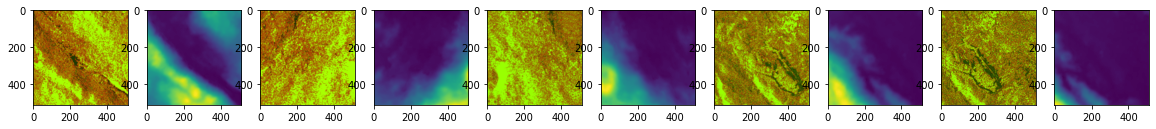

11it [00:06,  2.02it/s]

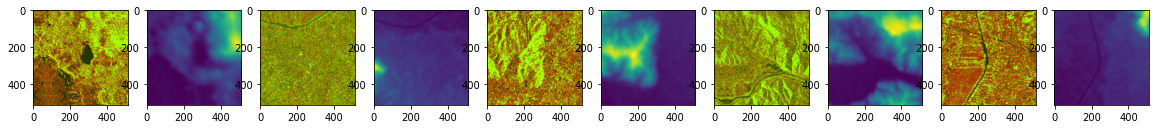

15it [00:07,  2.24it/s]

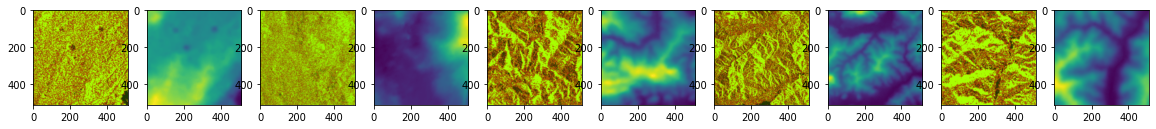

46it [00:19,  2.38it/s]

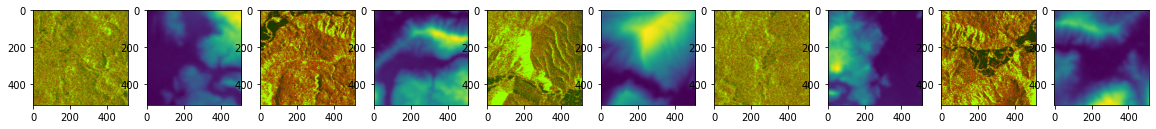

50it [00:21,  2.26it/s]

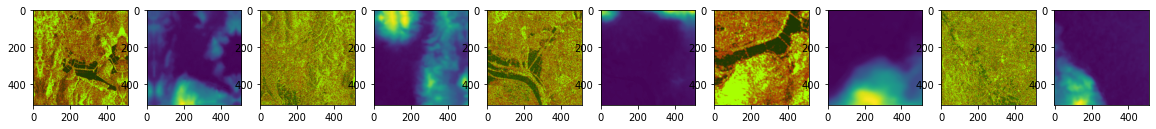

61it [00:24,  2.46it/s]


KeyboardInterrupt: 

In [12]:
for i, (images, label) in tqdm(enumerate(loader)):
    if i not in indices:
        continue
    else:
        images = invert(images)
        f, axes = plt.subplots(1, 10, figsize=(20, 5))
        for j in range(images.shape[0]):
            rgb = rgb_ratio(images[j], weights=(0.6, 1.1, 0.005))
            axes[j * 2].imshow(rgb)
            axes[j * 2 + 1].imshow(images[j][:,:,-1])
        plt.show()